# Python based multi-omic analyses
##### By: Robert Mills
##### Environment: python3

In [2]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import math
import seaborn as sns
from scipy.stats import ttest_ind
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Makes plots inline. This is prefered by the jupyter team
%matplotlib inline
# Sets your seaborn plot style. See: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(style= 'white', color_codes=True)

### User-defined functions

In [4]:
ttests=[]
def ttest(df,ttdf1,ttdf2):
    from scipy.stats import ttest_ind
    ttdf1 = ttdf1.transpose()
    ttdf2 = ttdf2.transpose()
    ttests = ttest_ind(ttdf1,ttdf2,equal_var=False,nan_policy='omit')
    ttests = ttests.pvalue.transpose()
    df['ttest_pvalue']=ttests

In [5]:
def fold(df, sub1, sub2, sub1name, sub2name):
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name,sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    print("Fold Change Column Name = 'Fold Change(%s/%s)'" %(sub1name,sub2name))
    

In [6]:
def piscore(df,sub1name,sub2name):
    df['Log2(Fold Change)'] = log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']

In [7]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)

In [8]:
def corr_compare_plots (df, sig_column,sig_level,category,human):
    """
    This function plots composition of the correlated proteins.
    Input the data frame you want to compare 
    the significance level and the name of the column to compare.
    
    Parameters
    ----------
    df : pd.DataFrame
    sig_column, String : provide the name of the column containing significance data
    sig_level, float : provide a quantitative cutoff for significance
    category : Name of variable you're comparing ratios of
    human : True/False, If you want to retain human proteins than "True"

    Returns
    -------
    Dataframe with comparative ratios
    Dataframe with counts
    Pdf plot of categories
    
    """
    #Subset out the significant positive and negative correlations
    Cal_neg = df[df[sig_column] < -sig_level]
    Cal_pos = df[df[sig_column] > sig_level]
    
    #pDB Use this code if you want to simply look at quantity of significant proteins
    Cal_neg['Positive Correlations'] = 0
    Cal_pos['Positive Correlations'] = 1
    Cal_neg['Negative Correlations'] = 1
    Cal_pos['Negative Correlations'] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])
    
    #Remove human proteins if desired    
    if human == True:
        df_sig = df_sig[df_sig['Taxonomic Annotation(Genus Level)'] != 'Homo sapiens (Human)']
        #dfcategories.drop('Homo sapiens (Human)', inplace=True)
    else:
        print('Human = False')
    
    #If you want to parse out your categories when there are multiple functions per protein hit...
    #You can plug and play whichever category you are interested in
    s = df_sig[category].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Categories'
    df_sig = df_sig.join(s)
    dfcategories = df_sig[['Positive Correlations','Negative Correlations']].groupby([df_sig['Parsed_Categories']]).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    counts = dfcategories
    
    #Add a Pseudocount of 1 so that the categories without anything are still shown
    dfcategories = counts.replace(0,1)
    
    dfcategories['Positive'] = \
    dfcategories['Positive Correlations']/dfcategories['Positive Correlations'].sum()
    dfcategories['Negative'] = \
    dfcategories['Negative Correlations']/dfcategories['Negative Correlations'].sum()

    dfcategories['Ratio of Percentages (Pos/Neg)'] = dfcategories['Positive']/dfcategories['Negative']
    
    dfcategories['Log10(Pos/Neg)'] = np.log10(dfcategories['Ratio of Percentages (Pos/Neg)'])
    
    global Ratios
    global Counts
    Ratios = dfcategories
    Counts = counts
    
    cols = ['Positive', 'Negative']
    
    dfcategories['sum'] = dfcategories[cols].sum(axis = 1)
    
    #Remove categories less than 3% of the total plot
    dfcategories = dfcategories[dfcategories['sum'] > 0.03]

    for i in cols:
        dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

    #Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

    #Remove index name
    del dfcategories.index.name
    #Sort samples by time
    order=['Negative', 'Positive']
    #Transpose
    dfcategories = dfcategories.transpose()
    #Get the dates in the correct order
    dfcategories = dfcategories.reindex(order)
    #Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
    dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

    #Get the number of colors to plot
    colors = len(dfcategories.columns)
    
    vals = np.linspace(0,1,colors)
    np.random.shuffle(vals)
    my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))
    
    plot1 = dfcategories.plot(kind='bar',stacked=True, colormap=my_cmap, title='%s Composition' % category)
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('./Composition_plot_%s_%s.pdf' % (category,sig_level),bbox_inches="tight")
    
    return 'Comparative ratios save under dataframe named Ratios, raw counts saved under dataframe name Counts'

### Import data

In [43]:
#df = pd.read_csv('./NormalizedDataAllAnnotations.csv', index_col = 'datarest$ProteinID')
df = pd.read_csv('./CSVs/NormalizedDataAllIDs.txt', sep = '\t', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./AllAnnotations.csv')
metadata = pd.read_csv('../Metadata_For_Proteomics.txt', sep = '\t')
Metabolite_meta = pd.read_csv('../Metabolomics/GNPS_Annotations/FEATURE-BASED-MOLECULAR-NETWORKING-1c02e49b-view_all_annotations_DB-main.tsv', sep = '\t')
MetaboDf = pd.read_csv('../Metabolomics/Metabolomics_table.csv')

In [10]:
df16S = pd.read_csv('./16S_Phylum_Counts.txt', sep = '\t', index_col = 'Phylum')

### Associations to Hyperbaric O2 treatment

<i> Replace missing values with the minimum value per sample for proteins </i>

In [44]:
samples = list(df.columns)

In [11]:
#MetaboDf.merge(Metabolite_meta, left_on = 'row ID', right_on = '#Scan#').to_csv('./MetabTableMerged.csv')

In [45]:
df_n = df[samples]
df_m = df[samples].T

for i in df_m:
    a = df_n.loc[i]
    df_n.loc[i].replace(np.nan, a.min(), inplace = True)

In [47]:
#Annotate proteins
dfMins = df_n.merge(protein_meta, left_index = True, right_on = 'datarest$ProteinID')

In [49]:
metadata.index = metadata['ProteomeID']

In [52]:
#Replace df for df with mins
df = dfMins

In [53]:
df.index = df['datarest$ProteinID']

,PD14,PD1,PD7,PD8,PD13,PD9,PD11,PD10,PD18,PD27,...,Cohort Origin,Taxonomic Annotation(Phylum Level),Taxonomic Annotation(Genus Level),KO,eggNOG,Sample Occurence Frequency,Individual Occurence Frequency,KEGG Functional Categories,eggNOG Functional Categories,Cohort Assembled
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
1006551.KOX_11045,303.537267,127.970628,86.403613,711.487603,94.574766,129.823230,301.704810,2409.747684,52.725859,52.725859,...,SP,Proteobacteria,Klebsiella,K00163,COG2609,0.090766,0.094393,Carbohydrate Metabolism,Energy production and conversion,EUR;CHN
1006551.KOX_14595,220.238945,396.814145,162.672498,3650.201925,871.137550,265.365779,179.241277,6438.417148,162.672498,162.672498,...,SP,Proteobacteria,Klebsiella,K00658,COG0508,0.034728,0.034579,Carbohydrate Metabolism,Energy production and conversion,EUR
1006551.KOX_26735,308.111060,280.528246,94.971672,4101.659930,153.330988,228.933834,373.575954,11228.489250,94.971672,94.971672,...,SP,Proteobacteria,Klebsiella,K00845,COG0837,0.016575,0.012150,Carbohydrate Metabolism,Carbohydrate transport and metabolism,NaN
1028307.EAE_00370,301.433092,316.801968,575.926818,1322.528157,305.957715,264.127890,245.572504,1954.068331,112.812325,112.812325,...,SP,Proteobacteria,Enterobacter,K08483,COG1080,0.071034,0.079439,Membrane Transport,Carbohydrate transport and metabolism,CHN
1028307.EAE_04955,149.721899,305.245682,136.590760,820.360940,665.960815,166.441316,128.961296,12104.546180,29.401164,29.401164,...,SP,Proteobacteria,Enterobacter,K02906,COG0087,0.169692,0.184112,Translation,"Translation, ribosomal structure and biogenesis",NaN
1028307.EAE_06480,586.434211,97.250552,117.192634,610.523387,1448.331822,145.882142,155.152639,2026.268042,4.452443,4.452443,...,SP,Proteobacteria,Enterobacter,K01803,COG0149,0.173639,0.190654,Carbohydrate Metabolism,Carbohydrate transport and metabolism,CHN
1033813.ECNA114_3664,13.259872,13.259872,13.259872,13.259872,13.259872,13.259872,13.259872,13.259872,13.259872,13.259872,...,SP,Proteobacteria,Escherichia,K01580,COG0076,0.459353,0.476636,Carbohydrate Metabolism,Amino acid transport and metabolism,NaN
1033813.ECNA114_3877,62.068642,62.068642,62.068642,62.068642,62.068642,62.068642,62.068642,62.068642,62.068642,62.068642,...,SP,Proteobacteria,Escherichia,K02040,COG0226,0.651144,0.671028,Membrane Transport,Inorganic ion transport and metabolism,EUR;CHN;USA
1045856.EcWSU1_00343,393.165361,61.392669,79.851641,1591.430200,858.174135,185.157511,124.402828,10318.301900,44.163269,44.163269,...,SP,Proteobacteria,Enterobacter,K04078,COG0234,0.119179,0.128972,"Folding, Sorting and Degradation","Posttranslational modification, protein turnov...",EUR;CHN


In [54]:
metadata['trial_arm'].drop_duplicates()

ProteomeID
not available          treatment
PD4                         sham
PD28             helathy_control
NaN               not applicable
PD20                not provided
Name: trial_arm, dtype: object

In [55]:
#Choose which trial arm you want to analyze
#MetadataTreatments = metadata[metadata['trial_arm'] == 'treatment']
MetadataTreatments = metadata[metadata['trial_arm'] == 'sham']

In [56]:
#Make lists of samples wih a particular exposure type
before = list(MetadataTreatments[MetadataTreatments['timepoint'] == '1'].index)
after = list(MetadataTreatments[MetadataTreatments['timepoint'] == '2'].index)


In [60]:
#subset out dataframes according to exposure type
beforedf = df[df.columns[df.columns.isin(before)]]
afterdf = df[df.columns[df.columns.isin(after)]]

In [61]:
TwoCategoryMaster(df, afterdf, beforedf, 'after', 'before')

Fold Change Column Name = 'Fold Change(after/before)'


/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [181]:
#Optional - save statistics associated with before or after each treatment type

#df.to_csv('./dataAllMins_beforeafter_piscores.csv')
#df.to_csv('./dataAllMins_beforeafterSham_piscores.csv')

In [182]:
#Option - remove all microbial proteins

#df_human = df[df['Taxonomic Annotation(Phylum Level)'] == 'Homo sapiens (Human)']
#df_human.to_csv('./dataAllMins_beforeafterSham_piscores_human.csv')

,PD14,PD1,PD7,PD8,PD13,PD9,PD11,PD10,PD18,PD27,...,KEGG Functional Categories,eggNOG Functional Categories,Cohort Assembled,ttest_pvalue,after Mean,before Mean,Fold Change(after/before),Log2(Fold Change),-Log(P-value),after/before pi score
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
A0A024R571,1033.348782,140.081613,125.324402,297.858509,160.150405,76.892137,807.398264,122.837491,600.747313,107.645556,...,early endosome [GO:0005769]; endocytic vesicle...,EH domain-containing protein 1 (EH-domain cont...,NaN,0.203491,244.421807,560.347534,0.436197,-1.196949,0.691454,-0.827636
A0A024R6I7,750.937364,225.138498,120.657211,186.923013,1225.244576,123.041795,871.745499,233.086438,500.962323,64.402909,...,extracellular space [GO:0005615],Alpha-1-antitrypsin (Serpin peptidase inhibito...,NaN,0.124922,204.222568,661.229903,0.308853,-1.695010,0.903362,-1.531208
A0A075B6H7,372.179104,87.081482,28.635832,128.446646,853.417764,40.719107,763.211968,54.708952,716.519214,114.899978,...,extracellular space [GO:0005615]; immune respo...,Immunoglobulin kappa variable 3-7 (non-functio...,NaN,0.056514,169.471025,507.507229,0.333928,-1.582390,1.247848,-1.974581
A0A075B6I0,703.925358,387.695966,213.725374,618.875074,1300.651107,331.934089,522.636799,386.103238,628.525963,115.315575,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 8-61,NaN,0.259511,264.003057,617.127534,0.427793,-1.225014,0.585844,-0.717667
A0A075B6I1,384.457882,277.048404,67.298956,521.086248,42.075852,199.324655,121.699578,2616.298261,234.222788,65.259476,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 4-60,NaN,0.726600,600.129754,403.999321,1.485472,0.570922,0.138705,0.079189
A0A075B6I9,847.346996,521.940140,94.587759,1409.032511,1667.623794,302.816135,183.331918,937.749978,336.915699,133.919910,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 7-46,NaN,0.200576,275.034593,808.702294,0.340094,-1.555996,0.697721,-1.085650
A0A075B6J9,373.197292,453.387341,236.653924,501.343186,442.901385,757.741043,136.138480,400.865033,127.745409,57.906101,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 2-18,NaN,0.170241,371.042178,565.264533,0.656404,-0.607343,0.768935,-0.467008
A0A075B6K4,401.868129,291.519648,89.027537,766.475100,543.543410,356.080518,340.362614,563.404634,308.143060,64.288697,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 3-10,NaN,0.117238,233.727672,475.491149,0.491550,-1.024590,0.930931,-0.953822
A0A075B6K5,379.759697,301.439932,141.279761,575.137770,1235.596488,344.619634,590.090448,629.239290,353.017409,65.486593,...,extracellular space [GO:0005615]; plasma membr...,Immunoglobulin lambda variable 3-9,NaN,0.122676,242.514926,661.787889,0.366454,-1.448295,0.911241,-1.319747


/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Human = False


/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'Comparative ratios save under dataframe named Ratios, raw counts saved under dataframe name Counts'

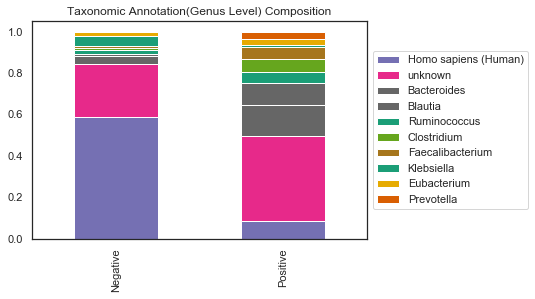

In [62]:
corr_compare_plots(df, 'after/before pi score', 1, 'Taxonomic Annotation(Genus Level)', human = False)

In [53]:
#Optional - save the ratios of positive or negative associations

#Ratios.to_csv('./BeforeAfterShamPi1_GenusRatios_noMins.csv')

In [54]:
#Optional - save the counts of positive or negative associations

#Counts.to_csv('./BeforeAfterShamPi1_GenusCounts_noMins.csv')

### Taxonomy barplot

#### 16S

In [83]:
df16S = pd.read_csv('./16S_Phylum_Counts.txt', sep = '\t', index_col = 'Phylum')

In [85]:
#16S
metadata.index = metadata['Sample_ID_noqiita']

,#SampleID,Sample_ID_noqiita,ProteomeID,PatientID_Treatment,host_subject_id,trial_arm,timepoint,BarcodeSequence,LinkerPrimerSequence,filename,...,response_d5,response_daytruefalse,sample_type,scientific_name,second_line_therapy,sex,steroids,taxon_id,title,Description
Sample_ID_noqiita,,,,,,,,,,,,,,,,,,,,,
dhmc.3.10,11149.dhmc.3.10,dhmc.3.10,not available,M3 after treatment,M3,treatment,2,XXQIITAXX,XXQIITAXX,not available,...,TRUE,TRUE,stool,human gut metagenome,FALSE,female,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
72848,11149.00007,72848,PD4,DH 10 before sham,DH 10,sham,1,XXQIITAXX,XXQIITAXX,72848.mzXML Peak area,...,FALSE,FALSE,stool,human gut metagenome,TRUE,female,FALSE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
dhmc.9.1,11149.dhmc.9.1,dhmc.9.1,PD24,DH 9 before sham,DH 9,sham,1,XXQIITAXX,XXQIITAXX,dhmc_9_1.mzXML Peak area,...,TRUE,TRUE,stool,human gut metagenome,FALSE,female,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
72846,11149.00007,72846,PD13,DH11 before sham,DH11,sham,1,XXQIITAXX,XXQIITAXX,72846.mzXML Peak area,...,TRUE,FALSE,stool,human gut metagenome,FALSE,male,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
72843,11149.00007,72843,PD14,P2 before sham,P2,sham,1,XXQIITAXX,XXQIITAXX,72843.mzXML Peak area,...,FALSE,FALSE,stool,human gut metagenome,TRUE,male,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
dhmc.1.1,11149.dhmc.1.1,dhmc.1.1,PD15,DH 1 before treatment,DH 1,treatment,1,XXQIITAXX,XXQIITAXX,dhmc_1_1.mzXML Peak area,...,TRUE,TRUE,stool,human gut metagenome,FALSE,female,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
dhmc.6.1,11149.dhmc.6.1,dhmc.6.1,PD22,DH 6 before treatment,DH 6,treatment,1,XXQIITAXX,XXQIITAXX,dhmc_6_1.mzXML Peak area,...,TRUE,TRUE,stool,human gut metagenome,FALSE,female,FALSE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
dhmc.7.1,11149.dhmc.7.1,dhmc.7.1,PD18,DH 7 before treatment,DH 7,treatment,1,XXQIITAXX,XXQIITAXX,dhmc_7_1.mzXML Peak area,...,FALSE,FALSE,stool,human gut metagenome,TRUE,female,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...
dhmc.8.1,11149.dhmc.8.1,dhmc.8.1,PD25,DH 8 before treatment,DH 8,treatment,1,XXQIITAXX,XXQIITAXX,dhmc_8_1.mzXML Peak area,...,FALSE,FALSE,stool,human gut metagenome,FALSE,male,TRUE,408170,hyperbaric oxygen pilot,hyperbaric oxygen intervention for ulcerative ...


In [86]:
#16S
df3 = df16S.T.merge(metadata, left_index = True, right_index = True).T
df3.columns = df3.loc['PatientID_Treatment']
samples = list(df3.columns)

In [94]:
#16S
taxalist = list(df16S.index)
dfcategories = df3.loc[taxalist]

PatientID_Treatment,DH 1 before treatment,P2 after sham,P2 before sham,M3 before treatment,DH12 before treatment,DH 7 after treatment,DH 7 before treatment,DH 6 before treatment,DH 8 after treatment,DH 9 before sham,DH 8 before treatment,DH13 before treatment,DH 1 after treatment,DH 9 after sham,DH 6 after treatment,DH11 before sham,DH13 after treatment,M1 after treatment,DH11 after sham,M3 after treatment
k__Bacteria;__,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
k__Bacteria;p__Actinobacteria,331,99,0,39,18,138,22,600,189,705,142,19,108,183,391,63,97,0,188,29
k__Bacteria;p__Bacteroidetes,3819,7551,7,8311,29,0,46,10477,5326,11,12313,13492,7972,212,137,3767,13938,17,7537,259
k__Bacteria;p__Firmicutes,8934,9056,14192,2115,10788,17912,9592,7113,11339,11428,5716,3776,6970,9539,17875,2830,5556,1746,6569,6270
k__Bacteria;p__Fusobacteria,4,0,45,0,0,0,0,0,0,165,0,691,0,284,0,0,0,1703,4,5
k__Bacteria;p__Proteobacteria,3294,2005,8835,2602,24,45,4937,599,54,5699,437,1751,293,6226,62,10967,907,17225,2604,254
k__Bacteria;p__Spirochaetes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
k__Bacteria;p__Tenericutes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
k__Bacteria;p__Verrucomicrobia,546,2,4,2659,0,0,0,0,0,0,2,0,13,0,0,3,0,2,3,0


In [95]:
for i in samples:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

In [97]:
order = ["Healthy1",
"Healthy2",
"Healthy3",
"Healthy4",
"DH 2 - not provided",
"DH 4 - not provided",
"DH 5 - not provided",
"M2 - not provided",
"DH 10 before sham",
"DH 9 before sham",
"DH11 before sham",
"P2 before sham",
"DH 10 after sham ",
"DH 9 after sham",
"DH11 after sham",
"P2 after sham",
"DH 1 before treatment",
"DH 6 before treatment",
"DH 7 before treatment",
"DH 8 before treatment",
"DH12 before treatment",
"DH13 before treatment",
"M1 before treatment",
"M3 before treatment",
"DH 1 after treatment",
"DH 6 after treatment",
"DH 7 after treatment",
"DH 8 after treatment",
"DH12 after treatment",
"DH13 after treatment",
"M1 after treatment",
"M3 after treatment"]

#Remove index name
#del dfcategories.index.name
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [100]:
dfcategories = dfcategories.dropna()

In [101]:
#Generate random colors
vals = np.linspace(0,1,9)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

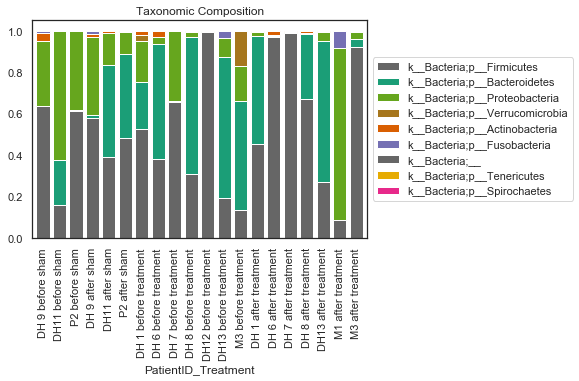

In [102]:
#Simple Plot
plot1 = dfcategories.plot(kind='bar', width = 0.8, stacked=True, colormap=my_cmap, title='Taxonomic Composition')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
#plt.savefig('HyperbaricO2_Composition_16S.pdf',bbox_inches="tight")

#### Metaproteome data

In [114]:
#df = pd.read_csv('./NormalizedDataAllAnnotations.csv', index_col = 'datarest$ProteinID')
df = pd.read_csv('./CSVs/NormalizedDataAllIDs.txt', sep = '\t', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./AllAnnotations.csv')
metadata = pd.read_csv('../Metadata_For_Proteomics.txt', sep = '\t')

In [122]:
samples = list(df.columns)

In [131]:
df2 = df.merge(protein_meta, left_index=True, right_on ='datarest$ProteinID')

In [132]:
dfcategories = df2[samples].groupby([df2['Taxonomic Annotation(Phylum Level)']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)
for i in samples:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

In [133]:
phyla = list(dfcategories.index)

In [134]:
dfcategories = dfcategories.T.merge(metadata,left_index=True,right_index=True)
dfcategories.index = dfcategories['PatientID_Treatment']
dfcategories = dfcategories[phyla].T

PatientID_Treatment,P2 after sham,M1 after treatment,M2 - not provided,DH11 after sham,DH11 before sham,P2 before sham,DH 1 before treatment,DH 5 - not provided,DH 8 after treatment,DH 7 before treatment,...,Healthy2,DH 10 after sham,Healthy3,Healthy4,DH 10 before sham,DH12 before treatment,DH13 before treatment,M3 before treatment,M1 before treatment,DH13 after treatment
Actinobacteria,0.009748,0.006676,0.006561,0.039239,0.029120,0.004981,0.023603,0.022135,0.034432,0.008926,...,0.010627,0.023754,0.009081,0.045205,0.018555,0.010310,0.018156,0.030984,0.015258,0.027646
Bacteroidetes,0.183214,0.034486,0.037947,0.084921,0.130786,0.032073,0.200398,0.119004,0.117340,0.049492,...,0.119192,0.128924,0.077976,0.170764,0.077595,0.061074,0.085611,0.172158,0.042555,0.088051
Cyanobacteria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000307,...,0.000537,0.000000,0.000290,0.000000,0.000000,0.000112,0.000000,0.000000,0.000000,0.000000
Euryarchaeota,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.000314,...,0.000427,0.000030,0.002553,0.000014,0.000019,0.000405,0.000018,0.000000,0.000000,0.000000
Firmicutes,0.290061,0.166282,0.090140,0.449811,0.149717,0.099130,0.350070,0.410216,0.458975,0.207081,...,0.551127,0.270861,0.512337,0.499857,0.215418,0.263929,0.178454,0.404612,0.166601,0.347095
Fusobacteria,0.002513,0.054511,0.001346,0.001215,0.001664,0.002766,0.000944,0.010823,0.000799,0.000099,...,0.000380,0.001257,0.000378,0.000738,0.000464,0.000125,0.001960,0.001732,0.020644,0.003940
Homo sapiens (Human),0.308539,0.181919,0.736867,0.229010,0.355565,0.718325,0.140738,0.221034,0.185268,0.559933,...,0.055358,0.405431,0.033925,0.030850,0.539873,0.454456,0.586176,0.166754,0.261801,0.283637
Lentisphaerae,0.000184,0.000013,0.001712,0.000000,0.000169,0.000485,0.000061,0.000000,0.000000,0.000154,...,0.000073,0.000780,0.000025,0.000010,0.000771,0.000229,0.000113,0.000097,0.000839,0.000082
Proteobacteria,0.070300,0.430181,0.046355,0.043581,0.213205,0.075567,0.009100,0.041543,0.020673,0.020296,...,0.010306,0.009732,0.018220,0.007551,0.007598,0.012003,0.007265,0.062043,0.377541,0.074091
Verrucomicrobia,0.001129,0.000488,0.000408,0.000406,0.002160,0.000289,0.000201,0.000486,0.000311,0.000706,...,0.000403,0.000468,0.001282,0.000310,0.000059,0.000770,0.000146,0.002489,0.001088,0.001327


In [135]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart
#M3 after treatment not ran for MS...

order = ["Healthy1",
"Healthy2",
"Healthy3",
"Healthy4",
"DH 2 - not provided",
"DH 4 - not provided",
"DH 5 - not provided",
"M2 - not provided",
"DH 10 before sham",
"DH 9 before sham",
"DH11 before sham",
"P2 before sham",
"DH 10 after sham ",
"DH 9 after sham",
"DH11 after sham",
"P2 after sham",
"DH 1 before treatment",
"DH 6 before treatment",
"DH 7 before treatment",
"DH 8 before treatment",
"DH12 before treatment",
"DH13 before treatment",
"M1 before treatment",
"M3 before treatment",
"DH 1 after treatment",
"DH 6 after treatment",
"DH 7 after treatment",
"DH 8 after treatment",
"DH12 after treatment",
"DH13 after treatment",
"M1 after treatment",
"M3 after treatment"]

#Remove index name
#del dfcategories.index.name
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

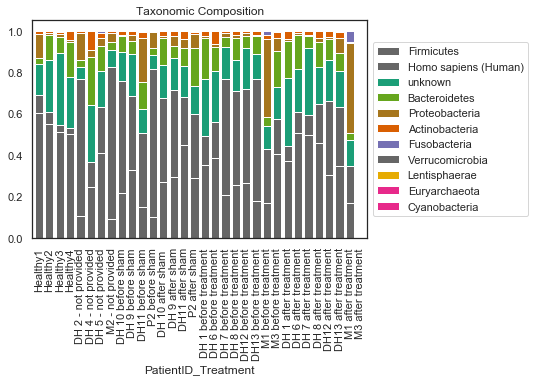

In [137]:
#Simple Plot
plot1 = dfcategories.plot(kind='bar', width = 0.8, stacked=True, colormap=my_cmap, title='Taxonomic Composition')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
#plt.savefig('HyperbaricO2_Composition_metaproteome.pdf',bbox_inches="tight")

### Metabolite comparisons

In [160]:
Metabolite_meta = pd.read_csv('../Metabolomics/GNPS_Annotations/FEATURE-BASED-MOLECULAR-NETWORKING-1c02e49b-view_all_annotations_DB-main.tsv', sep = '\t')
MetaboDf = pd.read_csv('../Metabolomics/Metabolomics_table.csv')
metadata = pd.read_csv('../Metadata_For_Metabolomics_qiime.txt', sep = '\t', index_col = 'MetaboID')

In [162]:
MetaboDf

,row ID,row m/z,row retention time,72843,72844,72845,72846,72847,72848,72849,...,dhmc_6_10,dhmc_7_1,dhmc_7_10,dhmc_8_1,dhmc_8_10,dhmc_9_1,dhmc_9_10,mayo_1_1,mayo_1_10,mayo_2
0,1,533.340207,3.618780,1.200000e+09,1.249441e+05,0.000000e+00,4.280000e+08,1.640000e+08,1.607809e+05,2.850000e+08,...,2.220000e+07,7.380000e+08,2.830000e+07,0.000000e+00,1.270877e+06,1.557150e+06,2.400000e+09,1.050000e+07,1.260000e+07,6.847456e+05
1,2,478.974667,3.897104,1.100000e+09,2.309542e+05,7.470636e+03,6.152814e+06,8.580000e+08,4.327716e+05,1.420000e+09,...,7.183053e+06,1.760000e+09,3.020000e+07,2.285282e+06,2.627895e+06,1.180000e+07,2.970000e+09,1.020000e+07,1.150000e+07,1.117249e+06
2,3,596.378183,4.093533,1.110000e+09,1.012960e+05,9.186104e+03,1.252135e+06,6.110000e+08,1.148595e+05,1.080000e+09,...,3.753940e+06,1.300000e+09,2.330000e+07,8.933515e+05,2.162891e+06,5.348561e+06,2.320000e+09,8.301716e+06,8.952341e+06,1.015159e+06
3,4,537.676270,4.001622,1.130000e+09,5.105075e+04,2.067316e+04,2.723823e+06,1.020000e+09,4.369506e+05,1.590000e+09,...,5.407092e+06,1.840000e+09,2.670000e+07,1.736162e+06,3.340453e+06,1.290000e+07,3.140000e+09,9.904869e+06,1.190000e+07,1.067727e+06
4,5,577.367337,3.696259,1.090000e+09,1.008243e+05,1.056794e+04,8.240000e+07,2.840000e+08,3.694630e+05,5.670000e+08,...,1.640000e+07,9.840000e+08,2.450000e+07,2.485604e+05,1.001148e+06,2.470008e+06,3.520000e+09,7.721571e+06,1.090000e+07,5.410811e+05
5,6,511.327010,3.573568,1.150000e+09,2.178456e+05,0.000000e+00,8.960000e+08,1.160000e+08,3.680471e+05,1.890000e+08,...,2.730000e+07,6.240000e+08,2.950000e+07,1.020224e+05,2.792171e+06,2.132883e+06,1.510000e+09,1.410000e+07,1.610000e+07,7.640749e+05
6,7,581.702784,4.069672,1.120000e+09,1.127561e+05,8.664210e+03,1.301327e+06,7.460000e+08,4.133760e+05,1.190000e+09,...,3.593213e+06,1.470000e+09,2.530000e+07,1.373475e+06,3.489867e+06,7.807248e+06,2.600000e+09,9.168678e+06,1.040000e+07,1.151540e+06
7,8,611.053455,4.116370,1.050000e+09,1.756182e+05,0.000000e+00,1.031730e+06,4.530000e+08,3.119987e+05,7.910000e+08,...,3.608896e+06,1.060000e+09,2.440000e+07,5.929108e+05,1.995972e+06,3.888561e+06,1.900000e+09,8.507240e+06,8.909900e+06,1.029648e+06
8,9,552.351782,4.029942,1.090000e+09,1.517252e+05,1.169789e+04,1.963234e+06,9.600000e+08,3.846493e+05,1.460000e+09,...,4.402442e+06,1.750000e+09,2.680000e+07,2.000956e+06,3.410808e+06,1.410000e+07,3.060000e+09,1.010000e+07,1.330000e+07,9.776190e+05
9,10,493.650137,3.924494,1.110000e+09,1.936293e+05,1.563776e+04,4.525432e+06,9.550000e+08,3.351515e+05,1.550000e+09,...,5.158543e+06,1.840000e+09,2.430000e+07,1.737817e+06,3.130787e+06,1.190000e+07,3.200000e+09,1.010000e+07,1.260000e+07,1.002993e+06


In [163]:
MetaboDf.index = MetaboDf['row ID']

In [164]:
MetadataTreatments = metadata[metadata['trial_arm'] == 'treatment']

In [165]:
#Make lists of samples wih a particular exposure type
before = list(MetadataTreatments[MetadataTreatments['timepoint'] == '1'].index)
after = list(MetadataTreatments[MetadataTreatments['timepoint'] == '2'].index)

In [166]:
#subset out dataframes according to exposure type
beforedf = MetaboDf[MetaboDf.columns[MetaboDf.columns.isin(before)]]
afterdf = MetaboDf[MetaboDf.columns[MetaboDf.columns.isin(after)]]

In [167]:
TwoCategoryMaster(MetaboDf, afterdf, beforedf, 'after', 'before')

Fold Change Column Name = 'Fold Change(after/before)'


#### Bile acid plots

In [169]:
samples = list(metadata.index)

In [171]:
np.log10(MetaboDf[samples].astype(float))

/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


,72844,mayo_1_10,mayo_2,72847,72846,72843,dhmc_1_1,dhmc_5_1,dhmc_8_10,dhmc_7_1,...,dhmc_8_1,dhmc_1_10,dhmc_6_10,72849,72848,72852,72845,dhmc_3_1,mayo_1_1,72851
row ID,,,,,,,,,,,,,,,,,,,,,
1,5.096716,7.100371,5.835529,8.214844,8.631444,9.079181,4.284957,4.934982,6.104104,8.868056,...,-inf,5.692169,7.346353,8.454845,5.206234,5.695047,-inf,5.552836,7.021189,4.390731
2,5.363526,7.060698,6.048150,8.933487,6.789074,9.041393,5.706621,5.833738,6.419608,9.245513,...,6.358940,-inf,6.856309,9.152288,5.636259,4.620033,3.873358,5.195313,7.008600,-inf
3,5.005592,6.951937,6.006534,8.786041,6.097651,9.045323,5.016681,5.466079,6.335035,9.113943,...,5.951022,-inf,6.574487,9.033424,5.060167,-inf,3.963131,4.402147,6.919168,-inf
4,4.708002,7.075547,6.028460,9.008600,6.435179,9.053078,5.559307,5.617160,6.523805,9.264818,...,6.239590,4.519308,6.732964,9.201397,5.640432,-inf,4.315407,5.135065,6.995849,-inf
5,5.003565,7.037426,5.733262,8.453318,7.915927,9.037426,5.078559,5.322727,6.000498,8.992995,...,5.395432,4.775125,7.214844,8.753583,5.567571,5.044870,4.023990,5.165621,6.887706,-inf
6,5.338149,7.206826,5.883136,8.064458,8.952308,9.060698,-inf,5.243525,6.445942,8.795185,...,5.008695,6.113227,7.436163,8.276462,5.565903,5.995105,-inf,5.926644,7.149219,5.342054
7,5.052140,7.017033,6.061279,8.872739,6.114386,9.049218,5.190580,5.622279,6.542809,9.167317,...,6.137821,-inf,6.555483,9.075547,5.616345,4.590399,3.937729,4.790252,6.962307,-inf
8,5.244569,6.949873,6.012689,8.656098,6.013566,9.021189,5.146415,5.590945,6.300154,9.025306,...,5.772989,4.458288,6.557374,8.898176,5.494153,-inf,-inf,4.559955,6.929789,-inf
9,5.181058,7.123852,5.990170,8.982271,6.292972,9.037426,5.524726,5.688364,6.532857,9.243038,...,6.301237,4.715552,6.643694,9.164353,5.585065,-inf,4.068108,5.348346,7.004321,4.514767


In [173]:
df = MetaboDf.merge(Metabolite_meta, left_index=True, right_on = '#Scan#', how = 'left')

In [175]:
df.index = df['row ID']

In [177]:
droplist = list(df['Compound_Name'].dropna().index)
droplist
#df = df.loc[droplist]

[24,
 46,
 49,
 53,
 264,
 280,
 287,
 336,
 345,
 389,
 471,
 501,
 517,
 529,
 577,
 602,
 643,
 695,
 739,
 748,
 768,
 780,
 791,
 820,
 835,
 849,
 852,
 883,
 887,
 921,
 924,
 944,
 965,
 973,
 980,
 981,
 988,
 1026,
 1032,
 1050,
 1066,
 1079,
 1080,
 1096,
 1097,
 1104,
 1108,
 1112,
 1137,
 1139,
 1143,
 1155,
 1158,
 1162,
 1177,
 1189,
 1191,
 1192,
 1197,
 1210,
 1211,
 1218,
 1227,
 1229,
 1234,
 1259,
 1263,
 1264,
 1269,
 1272,
 1275,
 1283,
 1286,
 1288,
 1312,
 1328,
 1351,
 1363,
 1367,
 1373,
 1392,
 1394,
 1396,
 1402,
 1411,
 1419,
 1434,
 1438,
 1453,
 1454,
 1465,
 1485,
 1487,
 1495,
 1497,
 1533,
 1534,
 1545,
 1569,
 1586,
 1596,
 1597,
 1598,
 1646,
 1670,
 1680,
 1688,
 1701,
 1712,
 1747,
 1781,
 1791,
 1820,
 1821,
 1824,
 1865,
 1895,
 1903,
 1906,
 1982,
 2037,
 2088,
 2112,
 2121,
 2133,
 2137,
 2175,
 2178,
 2184,
 2189,
 2211,
 2228,
 2232,
 2243,
 2252,
 2255,
 2290,
 2300,
 2315,
 2325,
 2329,
 2338,
 2360,
 2362,
 2391,
 2395,
 2450,
 2461,
 2500

In [178]:
df = df.loc[droplist]

,row ID,row m/z,row retention time,72843,72844,72845,72846,72847,72848,72849,...,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags,internalFilename
row ID,,,,,,,,,,,,,,,,,,,,,
24,24,182.081053,0.339291,1.180000e+09,6.830000e+08,2.370000e+07,7.450000e+08,1.120000e+09,6.810000e+08,2.140000e+08,...,7.0,NaN,1,182.081,specs_ms.mgf,CCMSLIB00003137613,1.69591e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
46,46,522.354775,6.390669,6.730000e+08,1.110000e+07,5.681700e+06,3.203045e+06,5.526874e+06,3.420000e+07,9.980000e+07,...,15.0,NaN,1,522.355,specs_ms.mgf,CCMSLIB00003136940,7.9413e+06,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
49,49,311.080015,3.571023,5.970000e+08,6.190000e+08,5.930000e+08,5.470000e+08,6.280000e+08,7.040000e+08,8.230000e+08,...,15.0,NaN,1,311.080,specs_ms.mgf,CCMSLIB00003138938,1.42209e+08,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
53,53,150.058319,0.313108,5.600000e+08,8.360000e+08,5.658985e+06,2.940000e+08,5.000000e+08,1.070000e+08,2.710000e+08,...,6.0,NaN,1,150.058,specs_ms.mgf,CCMSLIB00003139371,3.1e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
264,264,508.375591,6.567772,2.100000e+08,8.210000e+07,0.000000e+00,9.550676e+06,1.910000e+07,3.677342e+06,3.980000e+07,...,9.0,NaN,1,508.376,specs_ms.mgf,CCMSLIB00003138875,5.9194e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
280,280,165.054557,0.330012,2.320000e+08,1.360000e+08,4.527815e+06,1.500000e+08,2.140000e+08,1.280000e+08,3.860000e+07,...,6.0,NaN,1,165.055,specs_ms.mgf,CCMSLIB00003137783,1.979e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
287,287,205.097214,0.841347,5.720000e+08,5.290000e+09,1.180000e+07,7.630000e+09,2.130000e+09,1.740000e+09,1.410000e+09,...,7.0,C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N,1,205.097,specs_ms.mgf,CCMSLIB00000205165,1.553e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
336,336,217.154704,0.436070,2.760000e+08,5.720000e+08,1.660000e+07,1.850000e+08,5.870000e+08,3.690000e+08,9.880000e+07,...,6.0,NaN,1,217.155,specs_ms.mgf,CCMSLIB00003138752,2.368e+07,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf
345,345,518.321215,6.240434,2.930000e+08,5.200000e+07,1.060000e+07,5.750435e+06,2.060000e+07,8.900000e+07,4.860000e+07,...,11.0,NaN,1,518.321,specs_ms.mgf,CCMSLIB00003139839,1.1565e+06,UPDATE-SINGLE-ANNOTATED-BRONZE,,specs_ms.mgf


In [179]:
cholicdf = df[df['Compound_Name'].str.contains("holic")]

In [181]:
cholicdf.index = cholicdf['Compound_Name']

In [209]:
allBA = list(cholicdf.index)
len(allBA)

46

In [205]:
sigBA = list(cholicdf[cholicdf['after/before pi score'] > 1].index)

In [210]:
len(sigBA)

17

In [206]:
len(sigBA)/len(allBA)

0.3695652173913043

In [207]:
allBA

['Spectral Match to Taurocholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Glycoursodeoxycholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to 12-Ketodeoxycholic acid from NIST14',
 'Spectral Match to Ursodeoxycholic acid from NIST14',
 'Spectral Match to Chenodeoxycholic acid from NIST14',
 'Phenylalanocholic acid',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Tyrosocholic acid',
 'Spectral Match to Glycocholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Ch

In [208]:
sigBA

['Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Glycoursodeoxycholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Ursodeoxycholic acid from NIST14',
 'Phenylalanocholic acid',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Glycodeoxycholic acid from NIST14',
 'Spectral Match to Tauroursodeoxycholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Deoxycholic acid from NIST14',
 'Spectral Match to Tauroursodeoxycholic acid from NIST14',
 'Spectral Match to Glycoursodeoxycholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14']

In [183]:
biledfs = cholicdf[samples].T.merge(metadata, left_index = True, right_index = True).T

In [184]:
ids = ['timepoint', 'trial_arm']

In [186]:
bileacidslist = list(cholicdf.index)

In [188]:
bilemelt = pd.melt(biledfs.T, id_vars = ids, value_vars = bileacidslist)
bilemelt

,timepoint,trial_arm,variable,value
0,2,sham,Spectral Match to Taurocholic acid from NIST14,513578
1,2,treatment,Spectral Match to Taurocholic acid from NIST14,930164
2,not provided,not provided,Spectral Match to Taurocholic acid from NIST14,86459
3,2,sham,Spectral Match to Taurocholic acid from NIST14,3.27961e+06
4,1,sham,Spectral Match to Taurocholic acid from NIST14,481312
5,1,sham,Spectral Match to Taurocholic acid from NIST14,1.01e+08
6,1,treatment,Spectral Match to Taurocholic acid from NIST14,0
7,not provided,not provided,Spectral Match to Taurocholic acid from NIST14,0
8,2,treatment,Spectral Match to Taurocholic acid from NIST14,93862.3
9,1,treatment,Spectral Match to Taurocholic acid from NIST14,3.3e+07


In [189]:
bilemelt['TimeAndTrial'] = bilemelt['timepoint'].map(str) + ', ' + bilemelt['trial_arm'].map(str)

,timepoint,trial_arm,variable,value,TimeAndTrial
0,2,sham,Spectral Match to Taurocholic acid from NIST14,513578,"2, sham"
1,2,treatment,Spectral Match to Taurocholic acid from NIST14,930164,"2, treatment"
2,not provided,not provided,Spectral Match to Taurocholic acid from NIST14,86459,"not provided, not provided"
3,2,sham,Spectral Match to Taurocholic acid from NIST14,3.27961e+06,"2, sham"
4,1,sham,Spectral Match to Taurocholic acid from NIST14,481312,"1, sham"
5,1,sham,Spectral Match to Taurocholic acid from NIST14,1.01e+08,"1, sham"
6,1,treatment,Spectral Match to Taurocholic acid from NIST14,0,"1, treatment"
7,not provided,not provided,Spectral Match to Taurocholic acid from NIST14,0,"not provided, not provided"
8,2,treatment,Spectral Match to Taurocholic acid from NIST14,93862.3,"2, treatment"
9,1,treatment,Spectral Match to Taurocholic acid from NIST14,3.3e+07,"1, treatment"


In [190]:
bilemelt = bilemelt[bilemelt['timepoint'] != 'not provided']

In [192]:
bilemelt['logvalues'] = np.log10(bilemelt['value'].astype(float))

/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timepoint,trial_arm,variable,value,TimeAndTrial,logvalues
0,2,sham,Spectral Match to Taurocholic acid from NIST14,513578,"2, sham",5.710607
1,2,treatment,Spectral Match to Taurocholic acid from NIST14,930164,"2, treatment",5.968560
3,2,sham,Spectral Match to Taurocholic acid from NIST14,3.27961e+06,"2, sham",6.515822
4,1,sham,Spectral Match to Taurocholic acid from NIST14,481312,"1, sham",5.682427
5,1,sham,Spectral Match to Taurocholic acid from NIST14,1.01e+08,"1, sham",8.004321
6,1,treatment,Spectral Match to Taurocholic acid from NIST14,0,"1, treatment",-inf
8,2,treatment,Spectral Match to Taurocholic acid from NIST14,93862.3,"2, treatment",4.972491
9,1,treatment,Spectral Match to Taurocholic acid from NIST14,3.3e+07,"1, treatment",7.518514
10,2,sham,Spectral Match to Taurocholic acid from NIST14,6.18e+07,"2, sham",7.790988
11,2,treatment,Spectral Match to Taurocholic acid from NIST14,47608,"2, treatment",4.677680


In [194]:
bilemelt['values2'] = bilemelt['value'].astype(float)

/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [213]:
bilemelt2 = bilemelt
bilemelt2 = bilemelt2[bilemelt2['values2'] > 0]

In [216]:
#bilemelt2.to_csv('./BileacidsMeltno0s.csv')

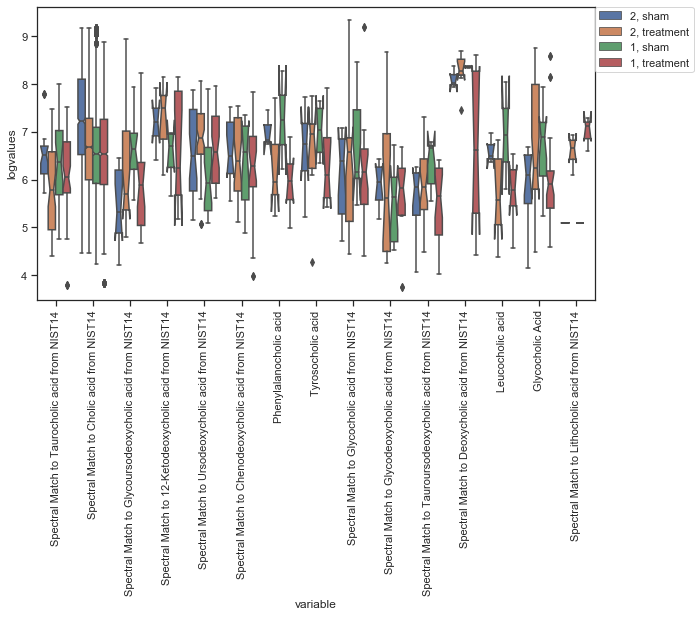

In [262]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize = a4_dims)
#sns.swarmplot(x = 'TimeAndTrial', y = "logvalues", hue = "variable", alpha=1, data = bilemelt2, palette=sns.hls_palette(12))
sns.boxplot(x="variable", y="logvalues",notch=True, hue = 'TimeAndTrial', data = bilemelt2)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
plt.savefig("./BileAcids_Boxplots_nozeros.pdf",bbox_inches='tight')

In [227]:
bilelist2 = list(bilemelt2['variable'].drop_duplicates())

In [232]:
bilemelt2[bilemelt2['variable'] == 'Spectral Match to Taurocholic acid from NIST14']

,timepoint,trial_arm,variable,value,TimeAndTrial,logvalues,values2
0,2,sham,Spectral Match to Taurocholic acid from NIST14,513578,"2, sham",5.710607,5.135782e+05
1,2,treatment,Spectral Match to Taurocholic acid from NIST14,930164,"2, treatment",5.968560,9.301642e+05
3,2,sham,Spectral Match to Taurocholic acid from NIST14,3.27961e+06,"2, sham",6.515822,3.279611e+06
4,1,sham,Spectral Match to Taurocholic acid from NIST14,481312,"1, sham",5.682427,4.813121e+05
5,1,sham,Spectral Match to Taurocholic acid from NIST14,1.01e+08,"1, sham",8.004321,1.010000e+08
8,2,treatment,Spectral Match to Taurocholic acid from NIST14,93862.3,"2, treatment",4.972491,9.386227e+04
9,1,treatment,Spectral Match to Taurocholic acid from NIST14,3.3e+07,"1, treatment",7.518514,3.300000e+07
10,2,sham,Spectral Match to Taurocholic acid from NIST14,6.18e+07,"2, sham",7.790988,6.180000e+07
11,2,treatment,Spectral Match to Taurocholic acid from NIST14,47608,"2, treatment",4.677680,4.760802e+04
14,1,treatment,Spectral Match to Taurocholic acid from NIST14,56264.8,"1, treatment",4.750237,5.626480e+04


In [237]:
#Lithocholic not IDed in enough samples
bilelist3 = bilelist2.remove('Spectral Match to Lithocholic acid from NIST14')

In [244]:
import pingouin as pg
bilestats = {}
for i in bilelist2:
    bilemelt3 = bilemelt2[bilemelt2['variable'] == i]
    posthoc = pg.pairwise_ttests(data=bilemelt3, dv='logvalues', subject='variable',within='TimeAndTrial',
                            padjust='fdr_bh', effsize='hedges')
    bilestats["%s" % i] = posthoc

In [247]:
bilelist2

['Spectral Match to Taurocholic acid from NIST14',
 'Spectral Match to Cholic acid from NIST14',
 'Spectral Match to Glycoursodeoxycholic acid from NIST14',
 'Spectral Match to 12-Ketodeoxycholic acid from NIST14',
 'Spectral Match to Ursodeoxycholic acid from NIST14',
 'Spectral Match to Chenodeoxycholic acid from NIST14',
 'Phenylalanocholic acid',
 'Tyrosocholic acid',
 'Spectral Match to Glycocholic acid from NIST14',
 'Spectral Match to Glycodeoxycholic acid from NIST14',
 'Spectral Match to Tauroursodeoxycholic acid from NIST14',
 'Spectral Match to Deoxycholic acid from NIST14',
 'Leucocholic acid',
 'Glycocholic Acid']

In [246]:
bilestats['Spectral Match to Taurocholic acid from NIST14']

,Contrast,A,B,Paired,Parametric,T,dof,tail,p-unc,p-corr,p-adjust,BF10,CLES,hedges
0,TimeAndTrial,"2, sham","2, treatment",True,True,4.065,73.03,two-sided,0.000120,0.000719,fdr_bh,198.389,0.710,0.830
1,TimeAndTrial,"2, sham","1, sham",True,True,0.709,26.00,two-sided,0.484910,0.484910,fdr_bh,0.256,0.580,0.221
2,TimeAndTrial,"2, sham","1, treatment",True,True,2.264,73.70,two-sided,0.026508,0.062835,fdr_bh,2.129,0.601,0.465
3,TimeAndTrial,"2, treatment","1, sham",True,True,-2.217,47.89,two-sided,0.031418,0.062835,fdr_bh,1.946,0.636,-0.535
4,TimeAndTrial,"2, treatment","1, treatment",True,True,-1.580,101.87,two-sided,0.117209,0.175814,fdr_bh,0.625,0.592,-0.307
5,TimeAndTrial,"1, sham","1, treatment",True,True,0.938,50.89,two-sided,0.352622,0.423147,fdr_bh,0.357,0.542,0.224


### Controlling for shifts in UC severity

#### Subsetting UC Severity samples for comparative analysis with hyperbaric samples

Samples were subset from a separate project investigating UC Severity. This analysis is intended to, as accurately as possible, reflect the degree of severity reflected in the patients whom recieved the hyperbaric treatment. This analysis falls one below the total partial mayo of 8 patients mimicking the before cohort and one partial mayo below a cohort of 8 patients mimicking the after cohort

In [125]:
mock_before = ['H1','H10','H14','H18','H19','H2','H20','H9']
mock_after = ['H12','H5','H6','H7','L10','L11','L13','L16']

In [141]:
#Load in dataframe from previous study
df = pd.read_csv('../../UC_Severity/smallDB_correct/CSVs/NormalizedDataAll.txt', sep = '\t', index_col = 'datarest$ProteinID')

#Create list of sample names
samples = list(df.columns)
samples

['H16',
 'H3',
 'L4',
 'L11',
 'H8',
 'L3',
 'H11',
 'H20',
 'L10',
 'L7',
 'L20',
 'H5',
 'H18',
 'L15',
 'H13',
 'L18',
 'L19',
 'H9',
 'H15',
 'L22',
 'H19',
 'H4',
 'L13',
 'H7',
 'L8',
 'L6',
 'H12',
 'L9',
 'L12',
 'H17',
 'L16',
 'H14',
 'H1',
 'L1',
 'H6',
 'L14',
 'H2',
 'H10',
 'L17',
 'L26']

In [142]:
#Deal with missing values as with hyperbaric O2
df_n = df[samples]
df_m = df[samples].T

for i in df_m:
    a = df_n.loc[i]
    df_n.loc[i].replace(np.nan, a.min(), inplace = True)

In [143]:
df_n.to_csv('./UCSEVERITY_IGC_DataAllwMin.csv')

In [144]:
df = df_n

In [145]:
#subset out dataframes according to 'exposure' type
beforedf = df[df.columns[df.columns.isin(mock_before)]]
afterdf = df[df.columns[df.columns.isin(mock_after)]]

In [146]:
TwoCategoryMaster(df, afterdf, beforedf, 'after', 'before')

Fold Change Column Name = 'Fold Change(after/before)'


In [149]:
#df.to_csv('./UCSEVERITY_IGC_dataAllMins_mockbeforeafter_piscores.csv')

In [263]:
#These tables were controlled for sample size, severity and statistical methods used - Used COMBINED dataset dependent background here
Hyp = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/DAVID_Pi1_Treatment_Table_bothdatasetbackground.txt', sep = '\t')
Sham = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/DAVID_Pi1_Sham_Table_bothdatasetbackground.txt', sep = '\t')
UC_Sev = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/UCSEVERE_Mock_DAVID_Pi1_Table_bothdatasetbackground.txt', sep = '\t')

In [241]:
##USING ONLY EXOSOME PROTEINS HERE
#These tables were controlled for sample size, severity and statistical methods used - Used COMBINED dataset dependent background here
Hyp = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/AllFoundExosomeBackground_Treatment_Table.txt', sep = '\t')
Sham = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/AllFoundExosomeBackground_Sham_Table.txt', sep = '\t')
UC_Sev = pd.read_csv('./Controlled_hyperbaric_functional_comparisons/AllFoundExosomeBackground_MockTreatments_Table.txt', sep = '\t')

In [264]:
df = Hyp.merge(Sham, left_on = 'Term', right_on = 'Term', how = 'outer')
df = df.merge(UC_Sev, left_on = 'Term', right_on = 'Term', how = 'outer')

In [265]:
df

,Category_x,Term,Count_x,%_x,PValue_x,Genes_x,List Total_x,Pop Hits_x,Pop Total_x,Fold Enrichment_x,...,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,GOTERM_CC_DIRECT,GO:0070062~extracellular exosome,500.0,69.156293,1.775573e-19,"P46940, P17655, P16278, P07437, Q13200, O75964...",714.0,1170.0,2063.0,1.234767,...,61.681329,5.844440e-09,"P01619, P46940, P17655, P07437, Q07065, Q13200...",998.0,1170.0,2063.0,1.114839,0.000004,0.000004,0.000009
1,UP_KEYWORDS,Acetylation,387.0,53.526971,2.164594e-10,"P46940, P07437, P17655, Q13200, Q9NTJ5, O75351...",722.0,934.0,2119.0,1.216068,...,49.560117,7.214951e-07,"P46940, Q07065, P07437, P17655, Q13200, Q9NTJ5...",1023.0,934.0,2119.0,1.124389,0.000350,0.000350,0.001035
2,GOTERM_BP_DIRECT,GO:0002576~platelet degranulation,42.0,5.809129,3.316898e-09,"P04196, P02751, P08567, P01033, P18206, P13473...",703.0,56.0,2014.0,2.148649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GOTERM_CC_DIRECT,GO:0005925~focal adhesion,88.0,12.171508,2.091123e-08,"P46940, E9PR17, P17655, Q13045, P36578, Q9ULV4...",714.0,157.0,2063.0,1.619511,...,10.850440,8.347216e-09,"P46940, P17655, P36578, Q14289, P61769, P07737...",998.0,157.0,2063.0,1.461477,0.000006,0.000003,0.000013
4,GOTERM_MF_DIRECT,GO:0044822~poly(A) RNA binding,146.0,20.193638,1.585285e-07,"Q12906, P36578, P52597, G8JLB6, Q5STZ8, P62753...",697.0,302.0,2005.0,1.390681,...,15.933529,2.842788e-02,"Q07065, P36578, P53597, G8JLB6, Q02252, Q99714...",972.0,302.0,2005.0,1.113342,1.000000,0.980139,37.333612
5,GOTERM_CC_DIRECT,GO:0031093~platelet alpha granule lumen,26.0,3.596127,4.770861e-07,"P04196, P02751, P01033, P04075, P04217, A0A024...",714.0,32.0,2063.0,2.347602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GOTERM_CC_DIRECT,GO:0042470~melanosome,43.0,5.947441,5.012076e-07,"P07355, P62820, P27105, Q15286, G5EA09, P31946...",714.0,65.0,2063.0,1.911420,...,4.301075,2.471587e-03,"P62820, P51151, Q15286, G5EA09, P31946, P51159...",998.0,65.0,2063.0,1.399291,0.814140,0.154879,3.649189
7,GOTERM_CC_DIRECT,GO:0072562~blood microparticle,65.0,8.990318,1.527459e-06,"P04196, P22792, P07357, A0A0D9SG88, P02774, P0...",714.0,115.0,2063.0,1.633114,...,7.820137,4.525232e-06,"P04196, P01619, P07357, A0A0D9SG88, P08603, P6...",998.0,115.0,2063.0,1.438006,0.003072,0.000769,0.006798
8,UP_KEYWORDS,Phosphoprotein,456.0,63.070539,1.181540e-05,"P46940, P07437, Q13200, O75351, P21964, A0A024...",722.0,1202.0,2119.0,1.113407,...,60.312805,8.506742e-04,"P46940, P07437, Q07065, Q13200, Q8NF50, O75351...",1023.0,1202.0,2119.0,1.063252,0.338174,0.050286,1.212863
9,GOTERM_CC_DIRECT,GO:0043209~myelin sheath,47.0,6.500692,2.455366e-05,"Q71U36, P31948, P29401, P68371, P21796, P11233...",714.0,81.0,2063.0,1.676540,...,5.767351,1.263041e-05,"Q71U36, P60709, Q32Q12, P68371, P11142, P38606...",998.0,81.0,2063.0,1.505690,0.008552,0.001716,0.018972


In [266]:
df = df.rename(columns = {'FDR_x':'FDR_Hyperbaric','FDR_y':'FDR_Sham','FDR':'FDR_Severe_UC'})

In [274]:
df3 = df.sort_values(by = 'FDR_Hyperbaric')
df3 = df3[df3.index < 17]

In [275]:
#df3 = df3[1:]

In [276]:
value_vars = ['FDR_Hyperbaric', 'FDR_Sham', 'FDR_Severe_UC']

In [277]:
fdr_melt = df3.melt(id_vars = 'Term', value_vars = value_vars)

In [278]:
fdr_melt['value_log'] = -np.log10(fdr_melt['value'])

In [279]:
fdr_melt = fdr_melt.dropna()

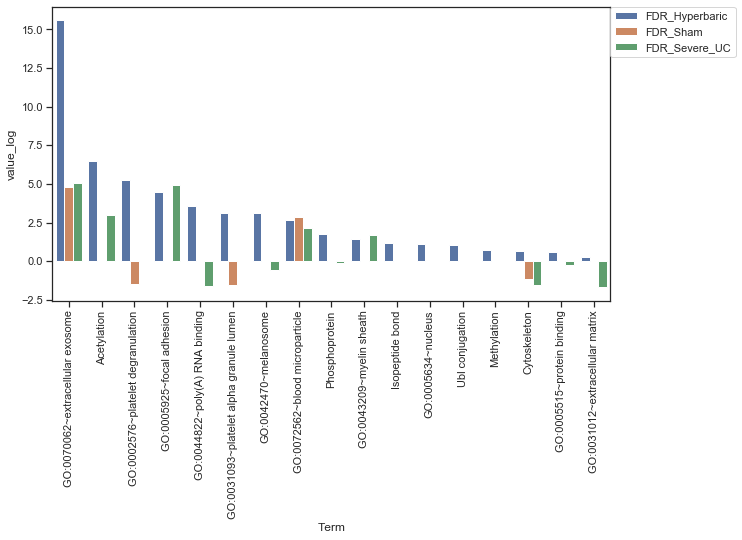

In [280]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize = a4_dims)
sns.barplot(x='Term', y = 'value_log', hue = 'variable', data = fdr_melt)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
#plt.savefig('./Human_Enrichment_comparisons_MockwSevereUC_bothdatasetsbackground_ExosomesOnly.pdf',bbox_inches='tight')

In [281]:
df3 = df3.rename(columns = {'Count_x':'Count_Hyperbaric','Count_y':'Count_Sham','Count':'Count_Severe_UC'})

In [282]:
value_vars = ['Count_Hyperbaric', 'Count_Sham', 'Count_Severe_UC']

In [283]:
count_melt = df3.melt(id_vars = 'Term', value_vars = value_vars)

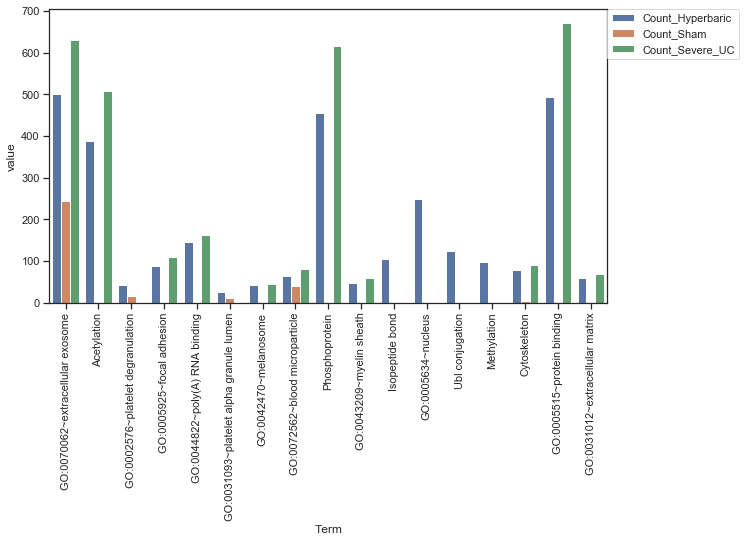

In [284]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize = a4_dims)
sns.barplot(x='Term', y = 'value', hue = 'variable', data = count_melt)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
#plt.savefig('./Human_Enrichment_comparisons_MockwSevereUC_counts_BothDatasetsBackground_ExosomesOnly_Counts.pdf',bbox_inches='tight')

### Compare the pi-scores of hyperbaric and mock treatment from UC Severity

In [292]:
mock = pd.read_csv('UCSEVERITY_IGC_dataAllMins_mockbeforeafter_piscores.csv', index_col = 'datarest$ProteinID')
Sham = pd.read_csv('./dataAllMins_beforeafterSham_piscores.csv', index_col = 'datarest$ProteinID')
Hyp = pd.read_csv('./dataAllMins_beforeafter_piscores.csv', index_col = 'datarest$ProteinID')

In [294]:
Sham_pi = Sham['after/before pi score']

In [295]:
Hyp['after/before sham pi score'] = Sham_pi

In [297]:
need_columns = ['after/before pi score','Fold Change(after/before)','ttest_pvalue']
mock = mock[need_columns]

In [298]:
mock = mock.rename(columns={'after/before pi score':'mock after/before pi score', 'Fold Change(after/before)': 'Fold Change(mock after/before)','ttest_pvalue':'mock_ttest_pvalue'})

In [300]:
df = Hyp.merge(mock, left_index=True,right_index=True)

,Unnamed: 0,PD14,PD1,PD7,PD8,PD13,PD9,PD11,PD10,PD18,...,Taxonomic Annotation(Phylum Level).1,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,after/before sham pi score,mock after/before pi score,Fold Change(mock after/before),mock_ttest_pvalue
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
P07148,8331,888.781334,70.456628,36.568293,895.251751,130.892297,33.320131,146.960888,80.717504,1333.158372,...,Homo sapiens (Human),P07148,#,Q13217,NaN,Q13217,-0.387239,-1.432194e+00,0.243418,0.198346
Q5T4U5,9040,865.744712,315.146799,135.597718,291.578571,609.700269,171.396041,721.299647,276.473197,348.494423,...,Homo sapiens (Human),Q5T4U5,#,P01042,NaN,P01042,-0.904267,-1.140875e+00,0.344517,0.181091
P42765,8699,1234.729965,117.086543,71.025015,221.836142,511.498555,43.190599,557.476469,267.769142,228.130879,...,Homo sapiens (Human),P42765,#,P50914,NaN,P50914,-0.470314,-9.221446e-01,0.221606,0.376545
P04040,8268,1035.699949,83.907006,45.680223,88.169916,235.141252,64.541482,752.900712,113.677120,1155.696043,...,Homo sapiens (Human),P04040,#,Q8TE67,NaN,Q8TE67,-1.964985,-1.459014e+00,0.219014,0.215803
P02768,8256,619.606550,124.977809,26.640976,52.389835,35.944909,62.940422,990.144437,68.547551,736.649120,...,Homo sapiens (Human),P02768,#,O75947,NaN,O75947,-0.589171,-3.601939e+00,0.033663,0.183574
P33121,8648,758.619075,214.598265,113.769255,166.494889,76.370985,156.077482,1335.107310,126.989006,385.039541,...,Homo sapiens (Human),P33121,#,NaN,NaN,Q13488,-0.088525,-1.694975e+00,0.175496,0.211273
P01024,8196,725.852857,180.587750,46.754298,102.157721,299.226708,109.790143,706.548176,111.402682,690.502889,...,Homo sapiens (Human),P01024,#,NaN,NaN,A0M8Q6,-0.864038,-1.357223e+00,0.222320,0.236781
P09917,8393,477.036984,413.670787,89.781832,619.118790,701.702617,91.983037,432.668640,149.750059,146.524995,...,Homo sapiens (Human),P09917,#,NaN,NaN,P30613,-0.225658,-1.533310e+00,0.181810,0.237999
P00505,8180,1567.930402,134.257601,58.891515,539.275766,1403.076394,80.066213,737.179723,235.445510,324.050194,...,Homo sapiens (Human),P00505,#,NaN,NaN,P06703,-1.504203,-1.753167e+00,0.167088,0.209327


In [302]:
df['Hyperbaric pi MINUS Mock pi'] = df['after/before pi score'] - df['mock after/before pi score']

,Unnamed: 0,PD14,PD1,PD7,PD8,PD13,PD9,PD11,PD10,PD18,...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,after/before sham pi score,mock after/before pi score,Fold Change(mock after/before),mock_ttest_pvalue,Hyperbaric pi MINUS Mock pi
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
P07148,8331,888.781334,70.456628,36.568293,895.251751,130.892297,33.320131,146.960888,80.717504,1333.158372,...,P07148,#,Q13217,NaN,Q13217,-0.387239,-1.432194e+00,0.243418,0.198346,-0.818625
Q5T4U5,9040,865.744712,315.146799,135.597718,291.578571,609.700269,171.396041,721.299647,276.473197,348.494423,...,Q5T4U5,#,P01042,NaN,P01042,-0.904267,-1.140875e+00,0.344517,0.181091,-0.749239
P42765,8699,1234.729965,117.086543,71.025015,221.836142,511.498555,43.190599,557.476469,267.769142,228.130879,...,P42765,#,P50914,NaN,P50914,-0.470314,-9.221446e-01,0.221606,0.376545,-0.934962
P04040,8268,1035.699949,83.907006,45.680223,88.169916,235.141252,64.541482,752.900712,113.677120,1155.696043,...,P04040,#,Q8TE67,NaN,Q8TE67,-1.964985,-1.459014e+00,0.219014,0.215803,-0.199668
P02768,8256,619.606550,124.977809,26.640976,52.389835,35.944909,62.940422,990.144437,68.547551,736.649120,...,P02768,#,O75947,NaN,O75947,-0.589171,-3.601939e+00,0.033663,0.183574,2.026231
P33121,8648,758.619075,214.598265,113.769255,166.494889,76.370985,156.077482,1335.107310,126.989006,385.039541,...,P33121,#,NaN,NaN,Q13488,-0.088525,-1.694975e+00,0.175496,0.211273,0.163294
P01024,8196,725.852857,180.587750,46.754298,102.157721,299.226708,109.790143,706.548176,111.402682,690.502889,...,P01024,#,NaN,NaN,A0M8Q6,-0.864038,-1.357223e+00,0.222320,0.236781,-0.102978
P09917,8393,477.036984,413.670787,89.781832,619.118790,701.702617,91.983037,432.668640,149.750059,146.524995,...,P09917,#,NaN,NaN,P30613,-0.225658,-1.533310e+00,0.181810,0.237999,0.144686
P00505,8180,1567.930402,134.257601,58.891515,539.275766,1403.076394,80.066213,737.179723,235.445510,324.050194,...,P00505,#,NaN,NaN,P06703,-1.504203,-1.753167e+00,0.167088,0.209327,0.412012


In [303]:
#Save comparisons and upload to String-DB
#df.to_csv('./Hyperbaric_and_mock_treatment_piscore_comparisons_onlyshared.csv')

### Calculate pin-drop statistics to determine whether HIF, VEGF or HO-1 interaction networks are related specifically to Hyperbaric O2

In [285]:
#df = pd.read_csv('../9606.protein.links.detailed.v11.0.txt', sep = ' ')
df2 = pd.read_csv('./Hyperbaric_and_mock_treatment_piscore_comparisons_onlyshared.csv')
df3 = pd.read_csv('./Hyperbaric_and_mock_treatment_piscore_comparisons_onlyshared_string_interactions_pindroppedONLY.txt', sep ='\t')
df3

,#node1,node2,UniprotID,Hyperbaric_minus_mock_PI,Abs_HypMinusMock,More_Associated_With_HBo2_or_Severity,node1_string_internal_id,node2_string_internal_id,node1_external_id,node2_external_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,MT1G,HMOX1,P13640,-2.684686,2.684686,Severity,4447689.0,4432912.0,9606.ENSP00000391397,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.412,0.412
1,CYCS,HMOX1,P99999,-2.542038,2.542038,Severity,4438356.0,4432912.0,9606.ENSP00000307786,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.063,0.000,0.0,0.698,0.705
2,ELANE,HMOX1,P08246,-1.739638,1.739638,Severity,4450799.0,4432912.0,9606.ENSP00000466090,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.511,0.511
3,CRP,HMOX1,P02741,-1.422248,1.422248,Severity,4434405.0,4432912.0,9606.ENSP00000255030,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.450,0.450
4,HSPA5,HMOX1,P11021,-1.253684,1.253684,Severity,4439666.0,4432912.0,9606.ENSP00000324173,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.495,0.495
5,FTH1,HMOX1,P02794,-1.250723,1.250723,Severity,4436083.0,4432912.0,9606.ENSP00000273550,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.095,0.000,0.0,0.580,0.604
6,ANXA5,HMOX1,P08758,-0.729045,0.729045,Severity,4437297.0,4432912.0,9606.ENSP00000296511,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.065,0.000,0.0,0.558,0.569
7,SOD1,HMOX1,P00441,-0.711455,0.711455,Severity,4435927.0,4432912.0,9606.ENSP00000270142,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.728,0.728
8,CDC42,HMOX1,P60953,-0.674537,0.674537,Severity,4446990.0,4432912.0,9606.ENSP00000383118,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.463,0.463
9,CP,HMOX1,P00450,-0.621618,0.621618,Severity,4435459.0,4432912.0,9606.ENSP00000264613,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.061,0.076,0.9,0.506,0.951


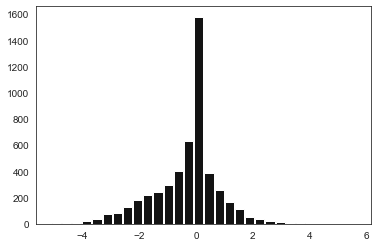

In [98]:
#Determine the distribution of the pi scores from the mock dataset
sns.set_style("white")
plt.hist(df2["mock after/before pi score"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./MockPI_Distribution.pdf')

In [99]:
#Descriptive statistics on the distribution
scipy.stats.describe(df2['mock after/before pi score'].dropna())

DescribeResult(nobs=4956, minmax=(-5.104920779904302, 5.652335816917227), mean=-0.33247088039579376, variance=1.3106651132732676, skewness=-0.4533167501548972, kurtosis=1.6907622286812396)

/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rhmills/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


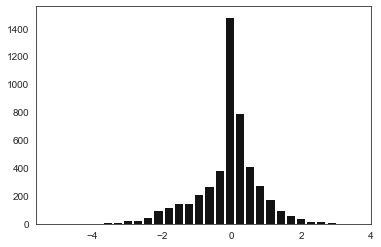

In [101]:
#Determine the distribution of the pi scores from the hyperbaric trial
sns.set_style("white")
plt.hist(df2["after/before pi score"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./HyperbaricPI_Distribution.pdf')

In [102]:
#Descriptive statistics on the distribution
scipy.stats.describe(df2['after/before pi score'].dropna())

DescribeResult(nobs=4935, minmax=(-5.188386929, 3.5821905430000003), mean=-0.10093793502906788, variance=0.8843686195548931, skewness=-0.5888154422238331, kurtosis=2.0322096088465704)

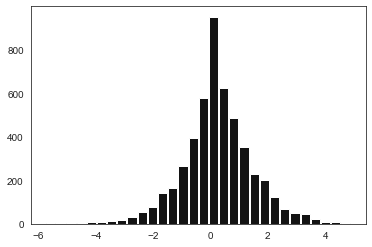

In [30]:
#Determine normal distribution of the pi score differences
plt.hist(df2["Hyperbaric pi MINUS Mock pi"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./HyperbaricMINUSMockPI_Distribution.pdf')

In [36]:
#Descriptive statistics on the distribution
scipy.stats.describe(df2['Hyperbaric pi MINUS Mock pi'].dropna())

DescribeResult(nobs=4935, minmax=(-5.752019808530737, 4.8910731046268765), mean=0.23288428791985138, variance=1.4782044706911592, skewness=-0.07607510527343185, kurtosis=1.551329688407364)

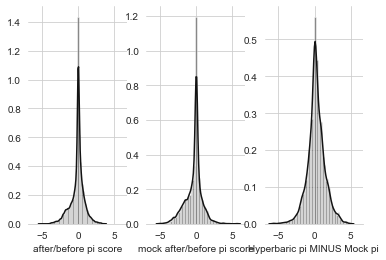

In [115]:
#Plot the distributions of the general pi score columns:

#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,3, sharex=True)
sns.despine(left=True)
sns.distplot(df2['after/before pi score'].dropna(), ax=axes[0],color ='#131313')
sns.distplot(df2['mock after/before pi score'].dropna(), ax=axes[1],color ='#131313')
sns.distplot(df2['Hyperbaric pi MINUS Mock pi'].dropna(), ax=axes[2],color ='#131313')
plt.savefig('./Piscores_distribution_plots.pdf')

Variance = 1.478, so standard deviation is close to 1.216.

Calculating where 95% of Pi scores should be (within 1.96 std): 1.216 * 1.96 = 2.383

95% of data lies within 0.233 +/- 2.383 pi scores

95% CI = (-2.15, 2.616)

In [286]:
#Determine the distribution of pi score differences for the proteins with a medium confidence level

df3.index = df3['#node1']
df4 = df3[df3['combined_score'] > 0.4]

In [289]:
df5

,#node1,node2,UniprotID,Hyperbaric_minus_mock_PI,Abs_HypMinusMock,More_Associated_With_HBo2_or_Severity,node1_string_internal_id,node2_string_internal_id,node1_external_id,node2_external_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
#node1,,,,,,,,,,,,,,,,,,,
MT1G,MT1G,HMOX1,P13640,-2.684686,2.684686,Severity,4447689.0,4432912.0,9606.ENSP00000391397,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.412,0.412
CYCS,CYCS,HMOX1,P99999,-2.542038,2.542038,Severity,4438356.0,4432912.0,9606.ENSP00000307786,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.063,0.000,0.0,0.698,0.705
ELANE,ELANE,HMOX1,P08246,-1.739638,1.739638,Severity,4450799.0,4432912.0,9606.ENSP00000466090,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.511,0.511
CRP,CRP,HMOX1,P02741,-1.422248,1.422248,Severity,4434405.0,4432912.0,9606.ENSP00000255030,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.450,0.450
HSPA5,HSPA5,HMOX1,P11021,-1.253684,1.253684,Severity,4439666.0,4432912.0,9606.ENSP00000324173,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.495,0.495
FTH1,FTH1,HMOX1,P02794,-1.250723,1.250723,Severity,4436083.0,4432912.0,9606.ENSP00000273550,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.095,0.000,0.0,0.580,0.604
ANXA5,ANXA5,HMOX1,P08758,-0.729045,0.729045,Severity,4437297.0,4432912.0,9606.ENSP00000296511,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.065,0.000,0.0,0.558,0.569
SOD1,SOD1,HMOX1,P00441,-0.711455,0.711455,Severity,4435927.0,4432912.0,9606.ENSP00000270142,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.728,0.728
CDC42,CDC42,HMOX1,P60953,-0.674537,0.674537,Severity,4446990.0,4432912.0,9606.ENSP00000383118,9606.ENSP00000216117,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.463,0.463


In [288]:
medium_conf_node_list = list(set(list(df4['#node1']) + list(df4['node2'])))
df5 = df3[df3.index.isin(medium_conf_node_list)]

In [291]:
df5['Hyperbaric_minus_mock_PI'].drop_duplicates()

#node1
MT1G    -2.684686
CYCS    -2.542038
ELANE   -1.739638
CRP     -1.422248
HSPA5   -1.253684
           ...   
VCL     -0.545946
VCP      0.335094
VTN      1.021758
VWF      0.424703
XRCC6   -0.164773
Name: Hyperbaric_minus_mock_PI, Length: 190, dtype: float64

In [292]:
#Save high confidence pi score distribution for later
medium_pis = df5['Hyperbaric_minus_mock_PI'].drop_duplicates()

In [294]:
#Determine distribution of pi scores for high confidence connections to pin dropped proteins
df4 = df3[df3['combined_score'] > 0.7]

In [295]:
high_conf_node_list = list(set(list(df4['#node1']) + list(df4['node2'])))
df5 = df3[df3.index.isin(high_conf_node_list)]

In [296]:
#Save high confidence pi score distribution for later
high_pis = df5['Hyperbaric_minus_mock_PI'].drop_duplicates()

In [297]:
#Determine distribution of pi scores for highest confidence connections to pin dropped proteins
df4 = df3[df3['combined_score'] > 0.9]

In [298]:
high_conf_node_list = list(set(list(df4['#node1']) + list(df4['node2'])))
df5 = df3[df3.index.isin(high_conf_node_list)]

In [299]:
#Save high confidence pi score distribution for later
highest_pis = df5['Hyperbaric_minus_mock_PI'].drop_duplicates()

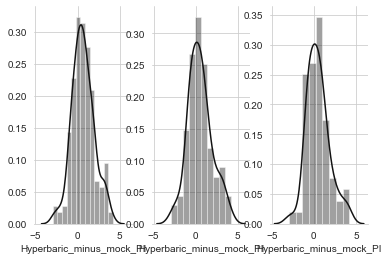

In [113]:
#Plot the distributions of medium, high and highest confidence proteins associated with pathways here:

#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,3, sharex=True)
sns.despine(left=True)
sns.distplot(medium_pis, ax=axes[0],color ='#131313')
sns.distplot(high_pis, ax=axes[1],color ='#131313')
sns.distplot(highest_pis, ax=axes[2],color ='#131313')
plt.savefig('./Pindrop_Interactors_PiDifferences_distribution_plots.pdf')

In [300]:
#Descriptive statistics on the distribution
scipy.stats.describe(medium_pis)

DescribeResult(nobs=190, minmax=(-2.9598606339999995, 4.219110676000001), mean=0.6518231113421052, variance=1.7266357479689616, skewness=0.1910028324275335, kurtosis=0.1653703363278214)

In [301]:
#Descriptive statistics on the distribution
scipy.stats.describe(high_pis)

DescribeResult(nobs=94, minmax=(-2.9598606339999995, 4.219110676000001), mean=0.515129008968085, variance=2.0645361752036364, skewness=0.35545917403154625, kurtosis=0.06890818097037821)

In [302]:
#Descriptive statistics on the distribution
scipy.stats.describe(highest_pis)

DescribeResult(nobs=65, minmax=(-2.9598606339999995, 4.219110676000001), mean=0.4894036035846154, variance=1.8460560997271285, skewness=0.5662028282699753, kurtosis=0.6584313314018138)